<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=132644338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚧 Work in progress 🚧 #

**<center><font size=5>RSNA-MICCAI Brain Tumor Classification</font></center>**

<center><img src="https://lingualab.ca/fr/project/language-recovery-psa/featured_hu67ab33455cf328a3b8dbb37d23762824_484672_720x0_resize_lanczos_2.png" alt="equal-2495950-1920" border="0" width="700"></center>

****

# 🚧 TODO Na pas oublier de mettre les sections ⚠️

**Table of Contents**
- <a href='#overview'>1. Project overview and objectives</a> 
    - <a href='#contributors'>1.1. Contributors</a>
    - <a href='#dataset_overview'>1.2. Data overview</a>
    - <a href='#definitions'>1.3. Imports, Methods, Paths, Reading definitions</a>
- <a href='#exploratory_data'>2. Exploratory Data</a>
    - <a href='#exploratory_data_2_1'>2.1. MRI  scans folders</a>
    - <a href='#exploratory_data_2_2'>2.2. MRI slides scans previews</a>
    - <a href='#exploratory_data_2_3'>2.3. MRI and MGMT values previews</a>
- <a href='#brain_segmentation'>3. Brain segmentation</a>
    - <a href='#brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
    - <a href='#brain_segmentation_3_2'>3.2. Selection Criteria</a>
    - <a href='#brain_segmentation_3_3'>3.3. Contributions of the Library</a>
- <a href='#utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_1'>4.1. Architecture</a>
    - <a href='#utilizing_unet_4_2'>4.2. Usage Instructions</a>
    - <a href='#utilizing_unet_4_3'>4.3. RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_4'>4.4. Usage Instructions</a>
- <a href='#dataset_creation_5'>5. Dataset creation</a>
- <a href='#exploratory_dataset'>6. Exploratory Dataset</a>
- <a href='#analysis'>7. Analysis Dataset</a>
    - <a href='#analysis_7_1'>7.1. Average Patient MGMT Comparison</a> 
    - <a href='#analysis_7_2'>7.2. Correlation Matrix</a> 
    - <a href='#analysis_7_3'>7.3. Univariate analysis</a>  
    - <a href='#analysis_7_4'>7.4. Bivariate analysis</a>           
- <a href='#clean_preprocessing_8'>8. Clean & Preprocessing</a>


****

# <a id='overview'>1. Project overview and objectives</a>

### Overview:

A malignant brain tumor is a life-threatening condition, specifically glioblastoma, which is the most common and has the poorest prognosis among adult brain cancers, with a median survival of less than a year. The presence of a specific genetic sequence called MGMT promoter methylation in the tumor has been identified as a favorable prognostic factor and a strong predictor of chemotherapy responsiveness.

Currently, the genetic analysis of cancer requires a surgical procedure to obtain a tissue sample, followed by a time-consuming process of determining the genetic characteristics of the tumor, which can take several weeks. Depending on the results and the chosen initial treatment, additional surgeries may be necessary. Developing an accurate method to predict the genetic profile of the cancer solely through imaging (known as radiogenomics) would potentially reduce the number of surgeries and allow for a more tailored therapy approach.

The Radiological Society of North America (RSNA) and the Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) have collaborated to enhance the diagnosis and treatment planning for glioblastoma patients.

### Competition:

In this competition, participants are tasked with using MRI (magnetic resonance imaging) scans to train and test a model that can predict the genetic subtype of glioblastoma by detecting the presence of MGMT promoter methylation.

Successful outcomes from this competition could significantly contribute to less invasive diagnoses and treatments for brain cancer patients. Introducing new and personalized treatment strategies before surgery holds the potential to improve the management, survival rates, and overall prospects of individuals affected by brain cancer.

### Acknowledgments:

The Radiological Society of North America (RSNA®) is a non-profit organization representing 31 radiologic subspecialties from 145 countries worldwide. RSNA promotes excellence in patient care and healthcare delivery through education, research, and technological innovation.

RSNA provides high-quality educational resources, publishes five top peer-reviewed journals, hosts the world's largest radiology conference, and is dedicated to shaping the future of the profession through the RSNA Research & Education (R&E) Foundation, which has funded $66 million in grants since its establishment. Additionally, RSNA actively supports and facilitates research in medical imaging artificial intelligence (AI) by sponsoring ongoing AI challenge competitions.

The Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) is committed to advancing research, education, and practice in the field of medical image computing, computer-assisted interventions, biomedical imaging, and medical robotics. The society achieves this objective by organizing high-quality international conferences, workshops, tutorials, and publications that promote the exchange and dissemination of advanced knowledge, expertise, and experiences produced by leading institutions, scientists, physicians, and educators worldwide.

A complete list of acknowledgments can be found on this page.

[RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

## <a id='contributors'>1.1. Contributors</a>

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)

## <a id='dataset_overview'>1.2. Data overview</a>

The dataset we will be working with consists of MRI data provided by the Radiological Society of North America (RSNA®) and the Medical Imaging Computation and Computer Assistance Society (MICCAI Society). The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

The **"train/"** directory contains the training files with the **"train_labels.csv"**

The **"test/"** directory contains the tests files for the competition with the **"sample_submission.csv"**

The files are mpMRI scans, this includes:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

## <a id='definitions'>1.3. Imports, Methods, Paths, Reading definitions</a>

### Imports

In [1]:
# Operating System and File System
import os 

# Basic
import math
from enum import Enum
from itertools import chain

# Data Manipulation and Analysis
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
# Animation Matplotlib
import matplotlib.animation as anim
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

# Warnings
import warnings  # For suppressing warnings

# JSON Handling
import json  # For working with JSON data

# Encoding and Decoding Binary Data
import base64  # For encoding and decoding binary data

# Interactive Widgets and Display
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import HTML, display  # For displaying HTML content
from IPython.display import Image as show_gif # GIF

# Deep Learning Framework
import torch  # For working with PyTorch deep learning framework

# DICOM File Handling
import pydicom  # For reading DICOM files
from pydicom import dcmread  # For reading DICOM files

# Image Processing and Filtering
import SimpleITK as sitk  # For image filtering
from PIL import Image  # For image processing using the Python Imaging Library (PIL)

# Machine Learning and Data Splitting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm

import itertools  
from itertools import permutations

# Additional Libraries
import glob # Fetch data recusif
!pip install pyradiomics > /dev/null  # Installing the pyradiomics library for radiomics feature extraction
import radiomics  # For extracting radiomics features from medical images

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Paths

In [2]:
# ------------------------------------#    
# Definition Version
# ------------------------------------#    

class DatasetVersion(Enum):
    V_2D = '2D'
    V_3D = '3D'
    
# ------------------------------------#  
# Paths
# ------------------------------------#  
    
# ------------#
# Folders
# ------------# 
base_folder_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_folder_path = f"{base_folder_path}train/"
dataset_folder_path = "../input/githut-rsna-miccai-brain-tumor-classification-ai/dataset/"

# ------------#
# Train / files
# ------------# 
train_labels_path = f"{base_folder_path}train_labels.csv"
submission_labels_path = f"{base_folder_path}sample_submission.csv"

dataset_3d_path = f"{dataset_folder_path}3d_rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
dataset_2d_path = f"{dataset_folder_path}2d_rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"

### Configure

#### **ℹ️ Configuration:**

- Flag to skip brain segmentation with PyTorch UNet
- Flag to set the dataset version 2D or 2D

👇🏻

In [3]:
# ------------------------------------#   
# Configuration
# ------------------------------------#    
    
# ℹ️ Flag to skip brain segmentation with PyTorch UNet
# If set to True, we will import the dataset that has already been generated
skip_brain_segmentation_pytorch_unet = True

# ℹ️ Set the dataset version to use when <skip_brain_segmentation_pytorch_unet = True>
dataset_version =  DatasetVersion.V_3D

# ------------------------------------#
# Configuration options
# ------------------------------------#

# Pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Suppressing Warnings
warnings.filterwarnings('ignore')

# Define "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

# Suppressing warnings SimpleITK
sitk.ProcessObject.SetGlobalWarningDisplay(False)

# ------------
# Segmentation
# ------------

# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 
                                    'unet', 
                                    in_channels=3, 
                                    out_channels=1, 
                                    init_features=32, 
                                    pretrained=True, 
                                    trust_repo=True)

# ------------
# Dataset
# ------------
# Dataset of the project, explanation in next section.    
preview_dataset = pd.read_csv(train_labels_path)
dataset = pd.read_csv(dataset_3d_path if dataset_version == DatasetVersion.V_3D else dataset_2d_path)
samp_subm = pd.read_csv(submission_labels_path)

/tmp/ipykernel_35/1824929013.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


### Methods

In [44]:
# ===============================================
# Base methods
# ===============================================

def is_even(nombre):
    return nombre % 2 == 0

def map_dataframe_to_tuples(df, columns):
    mapped_tuples = []
    for row in df.itertuples(index=False):
        mapped_tuple = tuple(getattr(row, col) for col in columns)
        mapped_tuples.append(mapped_tuple)
    return mapped_tuples
    
# ===============================================
# Images methods
# ===============================================

def get_processed_image(patient_id, dataset_version):
    """
    Retrieves and processes the images for a given patient, grouping them for segmentation.

    Args:
        patient_id (str): The ID of the patient (BraTS21ID).

    Returns:
        numpy.ndarray: A processed image composed of the different images of the patient.
    """
    # SEGMENTATION MODEL LIMITED TO 3 LAYERS
    # T2W SKIPPED
    patient_id = int(patient_id)

    # Paths for image sequences
    t1w_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T1w'
    #t2w_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T2w'

    flair_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/FLAIR'
    t1wce_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T1wCE'

    # Retrieve image sequences
    if dataset_version == DatasetVersion.V_2D:
        t1w_image = sequence_filenames(t1w_path)
        flair_image = sequence_filenames(flair_path)
        t1wce_image = sequence_filenames(t1wce_path)
        t2w_image = None
    else:
        t1w_image = sequence_filenames(t1w_path)
        flair_image = sequence_filenames(flair_path)
        t1wce_image = sequence_filenames(t1wce_path)
        t2w_image = None
        
    # Resampling
    if dataset_version == DatasetVersion.V_2D:
        re_sampled_flair = re_sample_image(flair_image, t1w_image)
        re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
        t2w_array = None
    else:
        re_sampled_flair = re_sample_image(flair_image, t1w_image)
        re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
        t2w_array = None

    
    # Normalization
    if dataset_version == DatasetVersion.V_2D:
        t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
        re_sampled_flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
        re_sampled_t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
        re_sampled_t2w_array = None
    else:
        t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
        re_sampled_flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
        re_sampled_t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
        re_sampled_t2w_array = None

    # Stack sequences
    if dataset_version == DatasetVersion.V_2D:
        sequence_stacked = np.stack([t1w_array, re_sampled_flair_array, re_sampled_t1wce_array])
        central_slice = t1w_array.shape[0] // 2
    else:
        sequence_stacked = np.stack([t1w_array, re_sampled_flair_array, re_sampled_t1wce_array])
        central_slice = t1w_array.shape[0] // 2

    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])


    
def sequence_filenames(path) :
    """
    Retrieves a sequence of images for a given directory.

    Args:
        path (str): The path to the directory containing the DICOM data set.

    Returns:
        SimpleITK.Image: A sequence of images corresponding to the DICOM files in the directory.

    Raises:
        FileNotFoundError: If the specified path does not exist.
    """
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

def normalize(dataset) :
    """
    Normalizes the data obtained from the images.

    Args:
        dataset (numpy.ndarray): The dataset to be normalized.

    Returns:
        numpy.ndarray: The normalized dataset.
    """
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))


def re_sample_image(image, ref_img):
    """
    Resamples the image to match the dimensions and properties of the reference image.

    Args:
        image (SimpleITK.Image): The image to be resampled.
        ref_img (SimpleITK.Image): The reference image used for resampling.

    Returns:
        SimpleITK.Image: The resampled image.
    """
    re_sampler = sitk.ResampleImageFilter()
    re_sampler.SetReferenceImage(ref_img)
    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

def segmentation_process(image_resized):
    """
    Obtains the segmented image.

    Args:
        image_resized (numpy.ndarray): The resized image.

    Returns:
        numpy.ndarray: The segmented image.
    """
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation
    
# ===============================================
# Dataset creation methods
# ===============================================

def init_dataset_radiomics() :
    """
    Initializes the DataFrame structures for radiomics data acquisition.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    if dataset_version == DatasetVersion.V_3D:
        df_shapes_columns = ['ID','BraTS21ID','MeshVolume','VoxelVolume','SurfaceArea','SurfaceVolumeRatio','Sphericity',
                             'Compactness1','Compactness2','SphericalDisproportion','Maximum3DDiameter','Maximum2DDiameterRow',
                             'Maximum2DDiameterColumn','MajorAxisLength','MinorAxisLenth','LeastAxisLength','Elongation','Flatness']

    else :
        df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                             'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']

    
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 


    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 
    

def add_patient_data2D(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)
    

def add_patient_data3D(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape.RadiomicsShape(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    
    shape3D = {}
    shape3D['ID'] = int(ID)
    shape3D['BraTS21ID'] = int(ID)
    shape3D['MeshVolume'] = results.getMeshVolumeFeatureValue()
    shape3D['VoxelVolume'] = results.getVoxelVolumeFeatureValue()
    shape3D['SurfaceArea'] = results.getSurfaceAreaFeatureValue()
    shape3D['SurfaceVolumeRatio']=results.getSurfaceVolumeRatioFeatureValue()
    shape3D['Sphericity'] = results.getSphericityFeatureValue()
    shape3D['Compactness1']=results.getCompactness1FeatureValue()
    shape3D['Compactness2']=results.getCompactness2FeatureValue()
    shape3D['SphericalDisproportion']=results.getSphericalDisproportionFeatureValue()
    shape3D['Maximum3DDiameter']=results.getMaximum3DDiameterFeatureValue()
    shape3D['Maximum2DDiameterRow']=results.getMaximum2DDiameterRowFeatureValue()
    shape3D['Maximum2DDiameterColumn']=results.getMaximum2DDiameterColumnFeatureValue()
    shape3D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape3D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape3D['LeastAxisLength'] = results.getLeastAxisLengthFeatureValue()
    shape3D['Elongation'] = results.getElongationFeatureValue()
    shape3D['Flatness'] = results.getFlatnessFeatureValue()
  
    df_shapes=df_shapes.append(shape3D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)    

    
# ===============================================
# Show methods
# ===============================================
    
def show_brain_segmentation(patient_id_mgmt_tuple_list, figsize, dataset_version):
    """
    Display a preview of patients from the given dataset.

    Args:
        patient_id_mgmt_tuples (list): List of tuples containing patient IDs and MGMT values. (Id, MGMT)
        dataset_version (str): Version of the dataset (2D or 3D).
    """
    # Loading
    loading_max = len(patient_id_mgmt_tuple_list)
    progress_bar = widgets.IntProgress(min=0, max=loading_max, description='Processing patients:', bar_style='info')
    display(progress_bar)

    # Process and display images for each patient
    for i, patient_id_mgmt_value in enumerate(patient_id_mgmt_tuple_list, start=1):
        # Process images for patient with MGMT value
        patient_id = patient_id_mgmt_value[0]
        patient_mgmt = patient_id_mgmt_value[1]
        img_resized = get_processed_image(patient_id, dataset_version)
        segmentation = segmentation_process(img_resized)
        show_segmentation(
            title = f"Patient {patient_id} and MGMT = {patient_mgmt}", 
            figsize = figsize, 
            img_src = img_resized, 
            dataset_version = dataset_version, 
            segmentation = segmentation
        )
        progress_bar.value = i + 1

    progress_bar.close()
    
def show_segmentation(title, figsize, img_src, dataset_version, segmentation):
    """
    Displays the resized source images and the segmentation image in a single line.

    Args:
        title (str): Global title for the plot.
        img_src (numpy.ndarray): Resized source images.
        segmentation (torch.Tensor): Segmentation image.

    Returns:
        None
    """
    if dataset_version == DatasetVersion.V_3D:
        titles = ['T1w', 'FLAIR', 'T1wce', 'Segmentation'] # T2w
    else:
        titles = ['T1w', 'FLAIR', 'T1wce', 'Segmentation'] # T2w
        
    # Create the main figure
    fig = plt.figure(figsize = figsize)

    # Adjust top margin for the main figure
    fig.subplots_adjust(top=0.85)

    # Set the global title
    fig.suptitle(title, y=0.75)

    # Iterate over the source images
    for i in range(3):
        ax = fig.add_subplot(1, 4, 1+i)
        ax.imshow(img_src[0, i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])

    # Add the segmentation image
    ax_segmentation = fig.add_subplot(1, 4, 4)
    ax_segmentation.imshow(segmentation.detach().numpy()[0, 0])
    ax_segmentation.set_title(titles[3])
    ax_segmentation.set_xticks([])
    ax_segmentation.set_yticks([])

    plt.tight_layout()
    plt.show()
    
    
def show_download_link(df, title = "Download CSV file", filename = "data.csv"):
    """
    Displays a download link for a DataFrame as a CSV file.

    Args:
        df (pandas.DataFrame): The DataFrame to be downloaded.
        title (str): The title of the download link (default: "Download CSV file").
        filename (str): The name of the downloaded file (default: "data.csv").

    Returns:
        None
    """
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    display(HTML(html))
    
    
def show_test_normality(df,graphic=True) : 

    describe = df.describe()
    
    for col in df.columns :

        skewness = stats.skew(df[col])
        kurtosis = stats.kurtosis(df[col],fisher=False)
        excess_kurtosis = stats.kurtosis(df[col])
        describe.loc['skewness',col] =  0.000001 if skewness == 0 else skewness
        describe.loc['kurtosis', col] =  0.000001 if kurtosis == 0 else kurtosis
        describe.loc['excess_kurtosis',col] =  0.000001 if excess_kurtosis == 0 else excess_kurtosis
        shapiro_test =  stats.shapiro(df[col])[1]
        describe.loc['shapiro_test',col] = shapiro_test
        describe.loc['normalite',col] = 'Oui' if shapiro_test > 0.05 else 'Non'

        if graphic : 
            figure_size = (6, 2)

            fig = plt.figure(figsize=figure_size)

            plt.subplot(1,3,1)
            sns.histplot(df[col], kde=True)
            plt.title('Histogramme de {}'.format(col),fontsize=8)
            plt.xlabel('Valeur',fontsize=7)
            plt.ylabel('Fréquence',fontsize=7)
            plt.plot(describe.loc['mean',col],0, marker="o", color="red")

            plt.subplot(1,3,2)
            plt.boxplot(x=df[col])
            plt.title('Boxplot de {}'.format(col),fontsize=8)
            #plt.xlabel('Valeur')

            plt.subplot(1,3,3)
            stats.probplot(df[col], plot=plt)
            plt.title('Q-Q plot pour {}'.format(col),fontsize=8)
            plt.xlabel('Quantile théorique',fontsize=7)
            plt.ylabel('Valeurs ordonnées',fontsize=7)
            plt.tight_layout()
            plt.show()

    return describe

def show_3D_scatter_plots(
    combinations_party,
    dataset, 
    title=None,
    figsize=(14, 25),
    elev_angle=30, 
    azimuth_angle=15, 
    show_legend=False,
    legend_loc='lower center',
    cmap='coolwarm',
    alpha=1.0
):
    """
    Display 3D scatter plots for each combination of variables in combinations_party using the given dataset.

    Args:
        combinations_party (list): List of combinations of variables to plot (x, y, z).
        dataset (DataFrame): The dataset containing the variables.
        figsize (tuple, optional): Figure size in inches. Defaults to (14, 25).
        elev_angle (float, optional): Elevation angle in degrees. Defaults to 30.
        azimuth_angle (float, optional): Azimuth angle in degrees. Defaults to 15.
        title (str, optional): Title for the plot. Defaults to None.
        show_legend (bool, optional): Whether to show the legend. Defaults to True.
        cmap (str, optional): Color map for the MGMT values. Defaults to 'coolwarm'.
        alpha (float, optional): Transparency of the data points. Defaults to 1.0.
    """
    num_combinations = len(combinations_party)
    num_rows = int(math.ceil(num_combinations / 2))
    num_cols = min(2, num_combinations)

    fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': '3d'}, figsize=figsize)

    # Loop to create scatter plots for each combination
    for i, combo in enumerate(combinations_party):
        if num_combinations == 1:
            ax = axes
        elif num_rows == 1:
            ax = axes[i]
        else:
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]

        value_x = combo[0]
        value_y = combo[1]
        value_z = combo[2]
        value_c = value_z
        
        x = dataset[value_x]
        y = dataset[value_y]
        z = dataset[value_z]
        c = dataset[value_c]
            

        # Display 3D scatter plot
        scatter = ax.scatter(x, y, z, c=c, cmap=cmap, alpha=alpha)

        # Add labels to axes
        ax.set_xlabel(value_x)
        ax.set_ylabel(value_y)
        ax.set_zlabel(value_z)
        ax.view_init(elev=elev_angle, azim=azimuth_angle)
        scatter.set_label(title)

        if show_legend:
            unique_values = np.unique(c)
            colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(unique_values)))
            labels = [f"{value_c} = {value}" for value in unique_values]
                    
            # Ajouter une légende personnalisée
            custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
            ax.legend(custom_legend, labels, loc=legend_loc, ncol=1)



    # Hide the last subplot if the number of combinations is odd
    if num_combinations % 2 == 1 and num_combinations > 1:
        axes[num_rows-1, num_cols-1].axis('off')

    fig.suptitle(title)  # Set the overall title for the plot

    fig.tight_layout()
    plt.show()
    plt.close()


def show_triangle_correlation_matrix(df, title="Correlation Matrix", filter_threshold=0):
    corr_df = df.corr()
    if filter_threshold > 0:
        corr_df = filter_correlation_matrix(corr_df, filter_threshold)

    plt.figure(figsize=(50, 20))
    mask = np.triu(np.ones_like(corr_df))
    ax = sns.heatmap(corr_df, annot=True, mask=mask, cmap="coolwarm")  # Ajout de linewidths
    plt.title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()


# ===============================================
# Dicom
# ===============================================

# ===============================================
# Correlation
# ===============================================

def generate_correlated_features_table(dataset, correlation_thresholds):
    """
    Generate a table of correlated features based on the given correlation thresholds.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        correlation_thresholds (list): List of correlation thresholds to consider.

    Returns:
        pd.DataFrame: The table of correlated features.
    """

    groups_correlated = {}

    for correlation_threshold in correlation_thresholds:
        groups_correlated[correlation_threshold] = find_highly_correlated_groups(dataset.corr(), correlation_threshold)

    # Préparer les données pour le tableau
    correlated_features = {}

    for correlation_threshold, groups_correlated_threshold in groups_correlated.items():
        correlated_features[correlation_threshold] = [", ".join(group_correlated) for group_correlated in groups_correlated_threshold if len(group_correlated) > 1]

    # Vérifier et ajuster les longueurs des listes
    max_length = max(len(features) for features in correlated_features.values())

    for features in correlated_features.values():
        features.extend([""] * (max_length - len(features)))

    # Créer un DataFrame avec les données
    df_correlated = pd.DataFrame(correlated_features)
    # Ajouter un titre au DataFrame
    df_correlated.columns.name = "Correlation Thresholds"

    return df_correlated

def extract_correlated_features(dataset, correlation_thresholds):
    """
    Extracts correlated features from a dataset based on given correlation thresholds.
    
    Args:
        dataset (pandas.DataFrame): The input dataset.
        correlation_thresholds (list): A list of correlation thresholds.
    
    Returns:
        numpy.ndarray: An array of correlated features.
    """
    correlation_features = generate_correlated_features_table(dataset.copy(), [correlation_thresholds])
    correlation_features = correlation_features.T.to_numpy()
    correlation_features = np.concatenate(correlation_features).ravel()
    correlation_features = [x for x in correlation_features if x != ""]
    correlation_features = [string.split(", ") for string in correlation_features]
    correlation_features = np.concatenate(correlation_features).ravel()
    
    return correlation_features


def filter_correlation_matrix(correlation_matrix, correlation_threshold):
    """
    Filters a correlation matrix by keeping only the absolute values greater than or equal to the correlation threshold.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold for filtering the matrix.

    Returns:
        pd.DataFrame: The filtered correlation matrix.

    """
    filtered_correlation_matrix = correlation_matrix.copy()
    filtered_correlation_matrix[abs(filtered_correlation_matrix) < correlation_threshold] = np.nan

    return filtered_correlation_matrix


def find_highly_correlated_groups(correlation_matrix, correlation_threshold = 0.8, filter_duplicated_group = True, convert_indices_to_column_names = True):
    """
    Finds groups of highly correlated variables from a correlation matrix.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold to consider as highly correlated.
        filter_duplicated_group (bool): Indicates whether to filter out duplicated values in the correlated groups.
        convert_indices_to_column_names (bool): Indicates whether to convert indices to column names.

    Returns:
        List[List[str]]: A list of groups, where each group contains the names of variables that are highly correlated.

    """
    n = correlation_matrix.shape[0]  # Number of variables in the correlation matrix
    groups_correlated = []  # List to store the correlated groups
    
    # Retrieve column names
    column_names = correlation_matrix.columns
    
    # Traverse each variable
    for i in range(n):
        if column_names[i] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
            group = [i]  # Create a new group containing the current variable (i)
            for j in range(i+1, n):
                if column_names[j] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
                    correlation = correlation_matrix.iloc[i, j]  # Retrieve the correlation between variables i and j
                    if abs(correlation) >= correlation_threshold:  # Strong correlation condition (adjust as needed)
                        group.append(j)  # Add variable j to the group
            
            groups_correlated.append(group)  # Add the group to the list of correlated groups
    
    # Filter out duplicated values in the correlated groups
    if filter_duplicated_group:
        filtered_groups_correlated = []
        for group in groups_correlated:
            filtered_group = list(set(group))  # Convert to a set to eliminate duplicates, then convert back to a list
            filtered_groups_correlated.append(filtered_group)
        groups_correlated = filtered_groups_correlated # Reset by new one
    
    # Convert indices to column names
    if convert_indices_to_column_names:
        groups_correlated = [[column_names[i] for i in group] for group in groups_correlated]
    
    return groups_correlated

<hr>

# <a id='exploratory_data'>2. Exploratory Data</a>

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

### ℹ️ **Note**: 
However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [5]:
total = len(preview_dataset)  # Nombre total d'échantillons
title = "Total number of files"
data = {title: [total]}

df = pd.DataFrame(data)
df.set_index(title, inplace=True)
df.head()

""
Total number of files
585


In [6]:
preview_dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The "train_labels.csv" file.

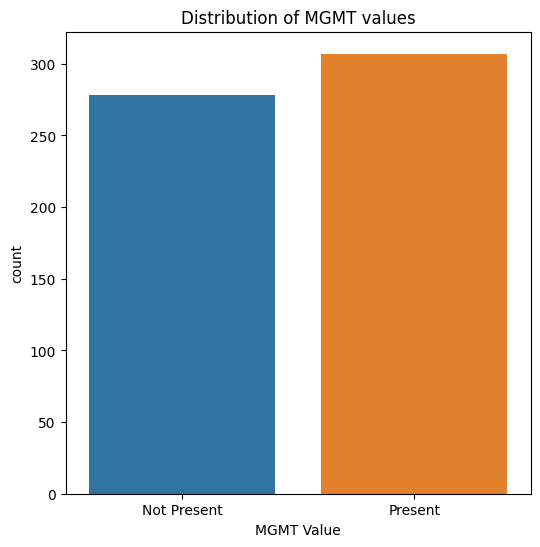

In [7]:
plt.figure(figsize=(6, 6))
sns.countplot(data=preview_dataset, x="MGMT_value")
plt.title("Distribution of MGMT values")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Not Present", "Present"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

In [8]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


### ℹ️ **Note**:
We deduce that we have to separate the sets of given train into part two part train and test for training.

## <a id='exploratory_data_2_1'>2.1. MRI  scans folders</a>

In [9]:
first_folder = str(preview_dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"
title = "Folders content for all patients"
# Folders content
folder_path = train_folder_path + first_folder  # Replace train_folder_path with the actual path
folder_content = os.listdir(folder_path)

df = pd.DataFrame({
        title: folder_content
    })
df.set_index(title, inplace=True)
df.head()

""
Folders content for all patients
T2w
T1wCE
T1w
FLAIR


In the first Dataset of the patient, we will explore the images contained in ['T2w', 'T1wCE', 'T1w', 'FLAIR'] of the first patient.

In [10]:
first_folder = str(preview_dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"
folder_path = train_folder_path + first_folder  # Replace train_folder_path with the actual path

title = 'Image Type'
flair_count = len(os.listdir(folder_path + 'FLAIR'))
t1w_count = len(os.listdir(folder_path + 'T1w'))
t1wce_count = len(os.listdir(folder_path + 'T1wCE'))
t2w_count = len(os.listdir(folder_path + 'T2w'))

data = {
    title: ['FLAIR', 'T1w', 'T1wCE', 'T2w'],
    'Count': [flair_count, t1w_count, t1wce_count, t2w_count]
}


df = pd.DataFrame(data)
df.set_index(title, inplace=True)


df.head()

,Count
Image Type,
FLAIR,400
T1w,33
T1wCE,129
T2w,408


## <a id='exploratory_data_2_2'>2.2. MRI slides scans previews</a>

In [11]:
image_path = "https://github.com/YanSteph/RSNA-MICCAI-Brain-Tumor-Classification-AI/blob/main/img/scan1.png?raw=true"
html_code = f'<img src="{image_path}" style="width: 700px;" />'
display(HTML(html_code))

## <a id='exploratory_data_2_3'>2.3. MRI and MGMT values previews</a>

Here is the list of examples of arguments supporting that an MRI is well performed and that the scans are appropriate for the study:

1. Image resolution and quality: A well-executed MRI will produce high-resolution images with clear image quality. This enables healthcare professionals to observe anatomical structures accurately and detect any potential abnormalities.

2. Proper contrast: The use of contrast agents during an MRI can enhance the visualization of certain structures or pathologies. When a scan is correctly performed, contrast will be applied appropriately, facilitating the identification of areas of interest.

3. Positioning and immobilization: High-quality MRI requires precise patient positioning and good immobilization to prevent unwanted movements during the procedure. When the patient is properly positioned and kept still, the obtained images will be more reliable and interpretable.

4. Appropriate acquisition protocol: Each type of MRI requires a specific acquisition protocol based on the body part being studied and the purpose of the examination. When the protocol is followed correctly, the images will provide the necessary information for diagnosis or study.

5. Accurate interpretation: Lastly, for an MRI to be well-executed and the scans ready for study, it is essential that interpretation is carried out by a qualified professional, such as a radiologist. Accurate interpretation of the images allows for the identification of potential abnormalities, proper diagnosis, and the recommendation of necessary treatments.

It is important to note that these arguments are general and that there are many more.

IntProgress(value=0, bar_style='info', description='Processing patients:', max=8)

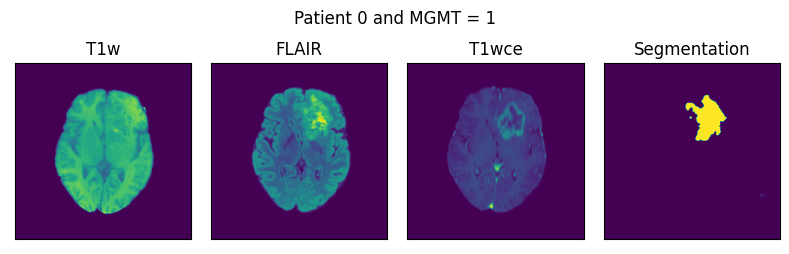

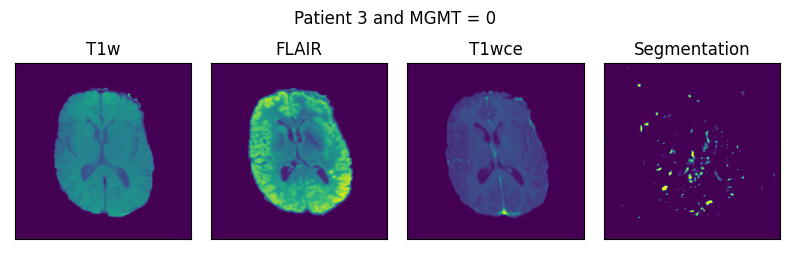

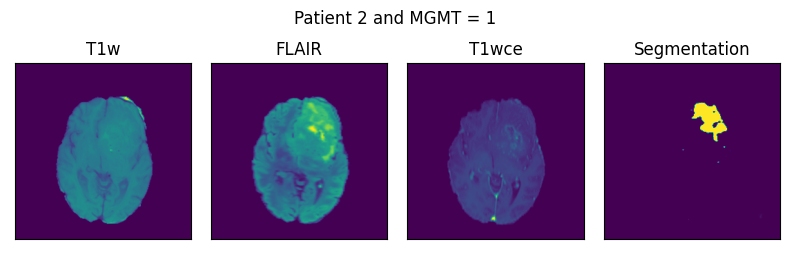

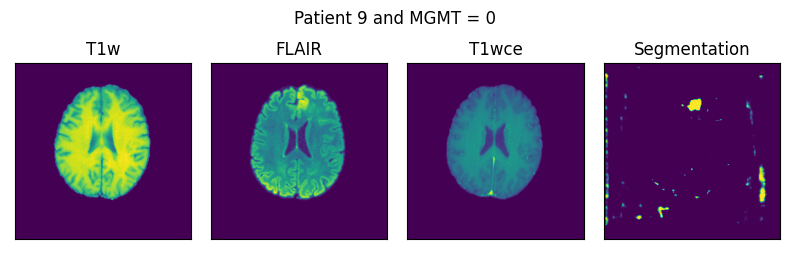

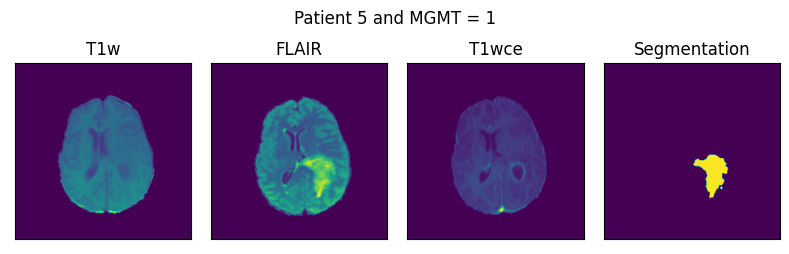

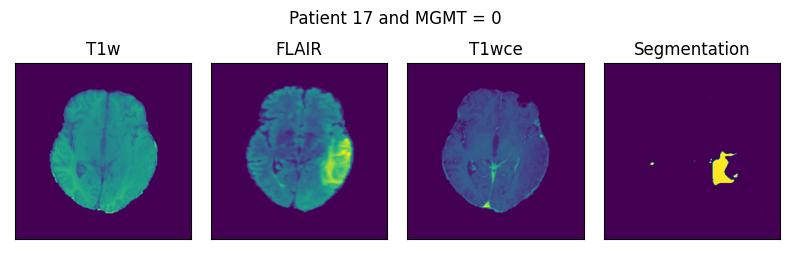

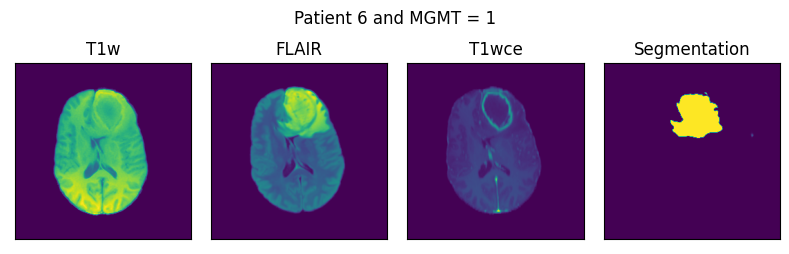

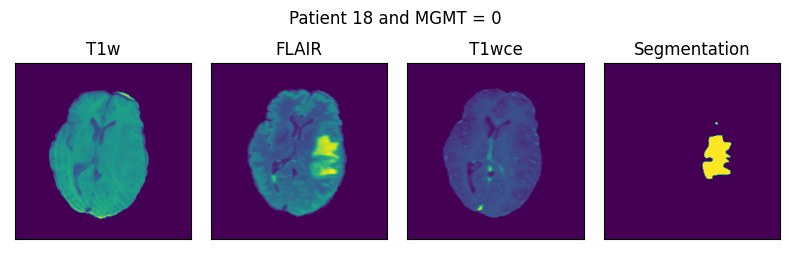

In [45]:
number_of_extraction = 4

# Filtre df mght 1 and 0
patient_without_mgmt = preview_dataset.loc[preview_dataset["MGMT_value"] == 0].sort_values('BraTS21ID')
patient_with_mgmt = preview_dataset.loc[preview_dataset["MGMT_value"] == 1].sort_values('BraTS21ID')

# Collonne selected
patient_with_mgmt_folder_ids = patient_with_mgmt[["BraTS21ID", "MGMT_value"]].iloc[:number_of_extraction]
patient_without_mgmt_folder_ids = patient_without_mgmt[["BraTS21ID", "MGMT_value"]].iloc[:number_of_extraction]

# map df into tupple
patient_with_mgmt_mapped_tuples = map_dataframe_to_tuples(patient_with_mgmt_folder_ids, ["BraTS21ID", "MGMT_value"])
patient_without_mgmt_mapped_tuples = map_dataframe_to_tuples(patient_without_mgmt_folder_ids, ["BraTS21ID", "MGMT_value"])

# Merge
patient_combined_with_and_without_mgmt_ids = list(chain.from_iterable(zip(patient_with_mgmt_mapped_tuples, patient_without_mgmt_mapped_tuples)))

# Show
show_brain_segmentation(patient_combined_with_and_without_mgmt_ids, figsize = (8, 5), dataset_version = dataset_version)

When an MRI is performed improperly or the scan is of poor quality, several issues can arise, potentially leading to adverse consequences for the patient. 

Here potential problems:

1. Image artifacts: A poorly performed MRI can result in artifacts, which are distortions or errors in the image. This can make interpretation difficult or even impossible, leading to incorrect or incomplete diagnoses.

2. Insufficient image quality: Improper execution of the MRI can lead to insufficient image quality. Inadequate resolution or excessive blurring can make it difficult to accurately identify anatomical structures or lesions, compromising the reliability of the diagnosis.

3. Positioning errors: Proper patient positioning is crucial during an MRI to obtain precise and consistent images. Incorrect positioning, such as poor immobilization or improper device calibration, can cause deformations and significant loss of information.

4. Motion artifacts: MRI often requires the patient to remain still during image acquisition. Any involuntary movement, such as tremors or respiratory motion, can introduce motion artifacts into the image. These artifacts can mask abnormalities or lead to incorrect interpretation of the results.

5. Parameter setting errors: The parameters used in an MRI, such as the acquisition sequence, echo time, or repetition time, need to be properly defined based on the clinical objective. Parameter setting errors can result in poor visualization of certain structures or inappropriate sensitivity to detect certain pathologies.

6. Region of interest not covered: When an MRI is poorly positioned or planning errors occur, it is possible that the region of interest may not be fully covered by the image. This can lead to a loss of essential information and incomplete evaluation of the area under examination, thereby compromising the accuracy of the diagnosis.


These are just an example. It is important to note that these problems are not exclusive to a single MRI scan. They can occur in exceptional circumstances or due to human error.

Here a preview of wrong IRM:

IntProgress(value=0, bar_style='info', description='Processing patients:', max=3)

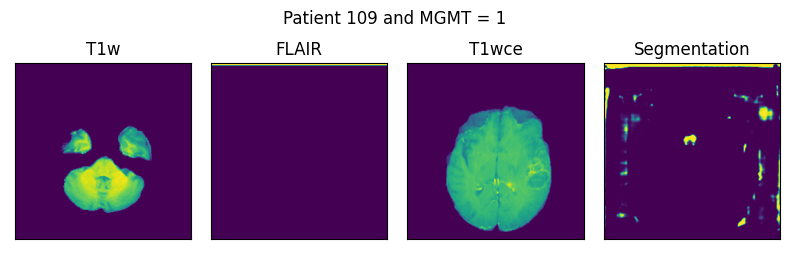

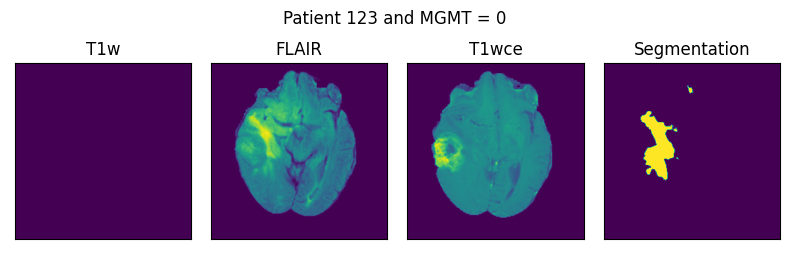

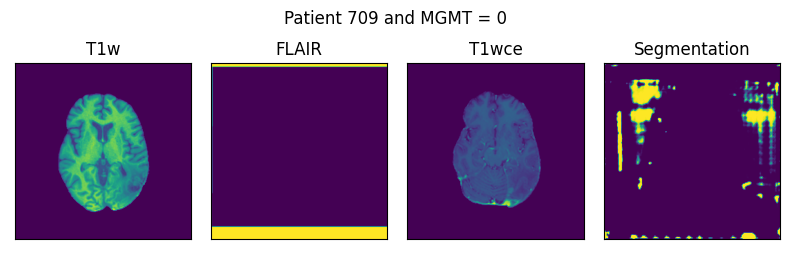

In [48]:
# Array of values
excluded_patient_ids = [109, 123, 709]  # Replace value1, value2, value3, ... with your actual values

patient_with_wrong_mri_ids = preview_dataset.loc[(preview_dataset["BraTS21ID"].isin(excluded_patient_ids))].sort_values('BraTS21ID')
patient_with_wrong_mri_ids_tuples = map_dataframe_to_tuples(patient_with_wrong_mri_ids, ["BraTS21ID", "MGMT_value"])

show_brain_segmentation(patient_with_wrong_mri_ids_tuples, figsize = (8, 5), dataset_version = dataset_version)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>We deduce that we have to separate the sets of given train into part two part train and test for training.</li>
            <li>Report on the main contest page, there are unexpected issues with the following cases in the training dataset, we will exclude these patient IDs:
                <ul>
                    <li>[109, 123, 709]</li>
                </ul>
            </li>
            <li>Exclusion of "/test" folder.</li>
        </ul>
    </div>
</div>
</br>
<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Excluded patient IDs: <b>`excluded_patient_ids`</b></li>
        </ul>
    </div>
</div>


----

# <a id='brain_segmentation'>3. Brain segmentation</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen to facilitate brain segmentation from medical images in our project. This section outlines the reasons behind selecting this library and its contribution to achieving accurate brain segmentation results.

Source: [mateuszbuda_brain-segmentation-pytorch_unet on PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

## <a id='brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
Brain segmentation is a crucial task in medical imaging as it enables the extraction of precise information about different regions or classes within the brain structures. Accurate segmentation plays a vital role in various medical applications, including tumor detection, anatomical analysis, and treatment planning.

## <a id='brain_segmentation_3_2'>3.2. Selection Criteria</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen based on the following criteria:

* **Exceptional Performance:** The library has demonstrated exceptional performance in brain segmentation tasks, providing accurate and reliable results.
Unet Architecture: It is specifically designed based on the Unet neural network architecture, which has a proven track record of success in biomedical image segmentation.
* **User-Friendly Nature:** The library offers a user-friendly interface and efficient implementation, allowing researchers and practitioners to easily integrate it into their projects.

## <a id='brain_segmentation_3_3'>3.3. Contributions of the Library</a>
The utilization of the "mateuszbuda_brain-segmentation-pytorch_unet" library significantly contributed to the acquisition of accurate brain segmentation data for our dataset. By leveraging the library's capabilities, we were able to efficiently segment medical images and extract valuable information for further analysis and research purposes.

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px;">
    <div class="card-body">
        <h2 class="card-title"><strong>📝 Note:</strong></h2>
        <p>
            In summary, the selection of the <b>"mateuszbuda_brain-segmentation-pytorch_unet"</b> library was based on its exceptional performance, user-friendly nature, and utilization of the powerful Unet architecture. This library played a pivotal role in achieving accurate brain segmentation results and provided a solid foundation for our project's objectives.
        </p>
    </div>
</div>

   
# 🚧 TODO to edit If we switch to 3D 
# <a id='utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape2D Class</a>
U-Net for Brain MRI Model
To accomplish tumor segmentation, we will employ the U-Net for Brain MRI model. This section provides an overview of the model's architecture and usage instructions.

## <a id='utilizing_unet_4_1'>4.1. Architecture</a>
The U-Net for Brain MRI model features a U-shaped architecture with branch connections and consists of four levels of blocks. Each block comprises two convolution layers with batch normalization, ReLU activation function, and an encoding part with a max pooling layer. The decoding part utilizes up-convolution. The number of convolution filters varies across the model's levels, ranging from 32 to 256.

## <a id='utilizing_unet_4_2'>4.2. Usage Instructions</a>
To utilize the U-Net for Brain MRI model, follow these steps:

Provide an input brain MRI image with three channels corresponding to pre-contrast, FLAIR, and post-contrast sequences.
Scale the image to a size of 256x256 pixels.
Normalize the image using the z-score method per volume.
The pre-trained U-Net model produces a single-channel probability map indicating anomalous regions in the input image. By applying an appropriate threshold to this probability map, it can be converted into a binary segmentation mask.

## <a id='utilizing_unet_4_3'>4.3. RadiomicsShape2D Class</a>
To perform shape analysis and extract relevant features, we will utilize the "radiomics.shape2D.RadiomicsShape2D" class. This class provides functionalities for analyzing the shape characteristics of segmented regions in medical images.

## <a id='utilizing_unet_4_4'>4.4. Usage Instructions</a>
To utilize the RadiomicsShape2D class, follow these steps:

Provide the segmented regions or masks obtained from the U-Net model.
Instantiate the RadiomicsShape2D class.
Use the available methods and functions to extract shape features, such as volume, surface area, compactness

Source: [Radiomics.shape2D.RadiomicsShape2D ](https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D)

# <a id='dataset_creation_5'>5. Dataset Preparation</a>

In order to proceed, we need to partition the given training dataset into two sets: training and testing. 

However, it is important to note that there are certain issues with three specific cases in the training dataset, namely [00109, 00123, 00709], as reported on the main contest page. 

Therefore, we will exclude these cases from the dataset.

ℹ️ Flag to skip brain segmentation with PyTorch UNet, default set to *True* else will import the dataset that has already been generated

In [47]:
if skip_brain_segmentation_pytorch_unet == False:
    loader = widgets.IntProgress(min=0, max=len(preview_dataset), description='Loading:')
    display(loader)
    
    # Empty creation of datasets
    init_dataset_radiomics()

    for i in preview_dataset.BraTS21ID :
        loader.value += 1
        img_resized = get_processed_image(i, dataset_version)
        segmentation = segmentation_process(img_resized)

        if dataset_version == DatasetVersion.V_3D:
            add_patient_data3D(i, img_resized, segmentation)
        else : 
            add_patient_data2D(i, img_resized, segmentation)

    # Join the 3 datasets
    df_shapes = df_shapes.set_index('ID')
    df_textures = df_textures.set_index('ID')
    df_first_orders_features = df_first_orders_features.set_index('ID')

    df = df_shapes.join(df_textures).join(df_first_orders_features)

    # Define 'BraTS21ID' column as integer IDs
    df['BraTS21ID'] = df['BraTS21ID'].astype(int)
    
    # Merge the old dataset with the new one
    dataset = pd.merge(preview_dataset, df, left_on='BraTS21ID', right_on='BraTS21ID')
    dataset.rename(columns={'BraTS21ID': 'ID'}, inplace=True)

# Patient BraTS21ID now is ID, and ID of Dataset
dataset = dataset.set_index('ID')
show_download_link(dataset)



<hr>

# <a id='exploratory_dataset'>6. Exploratory Dataset</a>

These features provide information about various properties of brain MRI images, such as shape, texture, and grayscale statistics. They are commonly used for analysis and classification of medical images to aid in the detection and characterization of brain pathologies.

Here is the requested list of features extracted from brain MRI images:

volume_features = ['MeshVolume', 'VoxelVolume', 'SurfaceArea']
shape_features = ['Sphericity', 'Compactness1', 'Compactness2', 'SphericalDisproportion']
dimension_features = ['Maximum3DDiameter', 'Maximum2DDiameterRow', 'Maximum2DDiameterColumn',
                      'MajorAxisLength', 'MinorAxisLenth', 'LeastAxisLength', 'Elongation', 'Flatness']
statistical_features = ['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency',
                        'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                        'DifferenceVariance', 'Id', 'Idm', 'Idmn', 'Idn', 'Imc1', 'Imc2',
                        'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 'MCC',
                        'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
descriptive_features = ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange',
                        'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median',
                        'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared',
                        'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']


**General features:** 
* **ID:** Sample identifier (Index).
* **MGMT_value:** Presence of MGMT.

**Volume features:** 

* **MeshVolume:** The volume of the ROI
* **VoxelVolume:** The volume of the ROI.This is a less precise approximation of the volume and is not used in subsequent features (Defined in IBSI as Approximate Volume).
* **SurfaceVolumeRatio:** A lower value indicates a more compact (sphere-like) shape. This feature is not dimensionless, and is therefore (partly) dependent on the volume of the ROI.

**Shape Features:**

* **Sphericity:** Sphericity is a measure of the roundness of the shape of the tumor region relative to a sphere.
* **Compactness1:** Similar to Sphericity, Compactness 1 is a measure of how compact the shape of the tumor is relative to a sphere 
* **Compactness2:** Similar to Sphericity and Compactness 1, Compactness 2 is a measure of how compact the shape of the tumor is relative to a sphere
* **SphericalDisproportion:** pherical Disproportion is the ratio of the surface area of the tumor region to the surface area of a sphere with the same volume as the tumor region, and by definition, the inverse of Sphericity.

**Dimension Features:**

* **Maximum3DDiameter:** Maximum 3D diameter is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices.
* **Maximum2DDiameterRow:** Maximum 2D diameter (Row) is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices in the column-slice (usually the sagittal) plane.
* **Maximum2DDiameterColumn:** Maximum 2D diameter (Column) is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices in the row-slice (usually the coronal) plane.
* **MajorAxisLength:** Major axis length, which is the length of the object's principal axis.
* **MinorAxisLenth:** Minor axis length, which is the length of the object's secondary axis.
* **LeastAxisLength:** This feature yield the smallest axis length of the ROI-enclosing ellipsoid and is calculated using the largest principal component λleast. In case of a 2D segmentation, this value will be 0.
* **Elongation:** Elongation shows the relationship between the two largest principal components in the ROI shape. For computational reasons, this feature is defined as the inverse of true elongation.
* **Flatness:** Flatness shows the relationship between the largest and smallest principal components in the ROI shape. For computational reasons, this feature is defined as the inverse of true flatness.

**Statistical Features:**

* **Autocorrelation:** Autocorrelation, measuring the similarity between grayscale levels of an image at different positions.
* **ClusterProminence:** Cluster prominence, measuring the asymmetry and regularity of pixel values within a cluster.
* **ClusterShade:** Cluster shade, measuring the symmetry of pixel values within a cluster.
* **ClusterTendency:** Cluster tendency, measuring the similarity of pixel values within a cluster.
* **Contrast:** Contrast, measuring the brightness differences between neighboring pixels.
* **Correlation:** Correlation, measuring the linear relationship between grayscale levels of an image in different directions.
* **DifferenceAverage:** Difference average, measuring the average differences between grayscale levels of neighboring pixels.
* **DifferenceEntropy:** Difference entropy, measuring the amount of information in the differences between grayscale levels of neighboring pixels.
* **DifferenceVariance:** Difference variance, measuring the variability of differences between grayscale levels of neighboring pixels.
* **Id, Idm, Idmn, Idn, Imc1, Imc2:** These texture-specific features are computed from gray-level co-occurrence matrices and measure different properties of the distribution of gray levels in the image.
* **InverseVariance:** Inverse variance, measuring the reciprocity of gray-level variance in the image.
* **JointAverage:** Joint average, measuring the average gray levels in neighborhood relationships.
* **JointEnergy:** Joint energy, measuring the sum of squared joint gray level values.
* **JointEntropy:** Joint entropy, measuring the amount of information contained in joint gray level values.
* **MCC:** Maximum correlation coefficient, measuring the maximum correlation between grayscale levels of an image in different directions.
* **MaximumProbability:** Maximum probability, measuring the maximum probability of joint grayscale values.
* **SumAverage:** Sum average, measuring the average sum of joint gray level values.
* **SumEntropy:** Sum entropy, measuring the amount of information contained in the sums of joint gray level values.
* **SumSquares:** Sum squares, measuring the sum of squared joint gray level values.


**Descriptive Features**

* **10Percentile:** 10th percentile, representing the value below which 10% of the pixels are found.
* **90Percentile:** 90th percentile, representing the value below which 90% of the pixels are found.
* **Energy:** Energy, measuring the sum of squared grayscale levels of pixels.
* **Entropy:** Entropy, measuring the amount of information contained in the grayscale levels of the image.
* **InterquartileRange:** Interquartile range, which is the difference between the 75th and 25th percentiles, providing
* **Kurtosis** Kurtosis is a measure of the ‘peakedness’ of the distribution of values in the image ROI. A higher kurtosis implies that the mass of the distribution is concentrated towards the tail(s) rather than towards the mean. A lower kurtosis implies the reverse: that the mass of the distribution is concentrated towards a spike near the Mean value.
* **Skewness** Kurtosis is a measure of the ‘peakedness’ of the distribution of values in the image ROI. A higher kurtosis implies that the mass of the distribution is concentrated towards the tail(s) rather than towards the mean. A lower kurtosis implies the reverse: that the mass of the distribution is concentrated towards a spike near the Mean value.


In [ ]:
dataset.head()

In [ ]:
dataset.info()

In [ ]:
dataset.describe()

### ℹ️ **Note**: 

| Context | Analysis Point | Short Note |
|---------|----------------|------------|
| Distribution & Outliers | Many of the variables have minimum values of 0, and most have means that are significantly higher than the median, suggesting positive skew. like **'LeastAxisLength', 'Flatness', 'TotalEnergy', 'Maximum3DDiameter', 'Energy', 'Variance' etc..**) |    1. The variables have positive skewness with large values. This can complicate data analysis.              
|                    |  | 2. See also in previous summary, patients:[00109, 00123, 00709 etc..] some patient with wrong data to remove.
|                    |  | 3. Apply feature scaling techniques to address the wide range of values and improve machine learning algorithm performance. |
| Zero Values  | Several variables such as **'LeastAxisLength'**, **'Flatness'**, and others show a minimum value of 0, which might indicate missing or incorrect data. | Missing data to remove |
| Absence of Negative Values  | Most variables do not contain negative values, which makes sense considering they seem to represent physical measurements. | Brain MRI |
| Potential Redundancy | The **'Id', 'Idm', 'Idmn', and 'Idn' etc..** variables appear to be very similar in terms of their statistical properties, which might indicate redundancy. | Potential Redundancy, so hight correlation, variables to remove. |
| Data Correlations | This basic statistical summary doesn't provide any information about possible correlations between **'MeshVolume', 'VoxelVolume'**, and **'MGMT_value'**. | The Brain size does not affect MGMT values  |
| Statistical Variables | The statistical variables included in the table, such as **'Mean', 'Median', 'Maximum', etc.**, are derived summaries or calculations based on other variables. | See the potential for analysis and perhaps potential exclusion. |

👉🏿 It's important to keep in mind that potential errors, biases, or other anomalies in how the data was gathered could influence these statistical properties.

----

# <a id='analysis'>7. Analysis</a>

In the analysis section, we are going to look at various features to discover their characteristics and identify significant differences.




## <a id='analysis_7_1'>7.1. Average Patient MGMT Comparison</a>

Here is a summary of the differences in values between an average patient with MGMT 1 (Mean) and an average patient with MGMT 0 (Mean) with the indication of the increase or decrease and indicating the potential impact in perentage.

In [ ]:
import pandas as pd
import numpy as np

# Select the first row for patients with MGMT_value = 1
patient_with_mgmt = dataset.loc[dataset["MGMT_value"] == 1].mean()

# Select the first row for patients with MGMT_value = 0
patient_without_mgmt = dataset.loc[dataset["MGMT_value"] == 0].mean()

# Transpose the dataframes
patient_with_mgmt = patient_with_mgmt.T
patient_without_mgmt = patient_without_mgmt.T

# Concatenate the transposed dataframes horizontally
patient_explore = pd.concat([patient_without_mgmt, patient_with_mgmt, patient_without_mgmt - patient_with_mgmt], axis=1)

# Rename the columns
patient_explore.columns = ['Patient MGMT 0 (Mean)', 'Patient MGMT 1 (Mean)', 'Difference']

# Calculate the percentage difference
patient_explore['Difference (%)'] = (patient_explore['Patient MGMT 1 (Mean)'] - patient_explore['Patient MGMT 0 (Mean)']) / patient_explore['Patient MGMT 0 (Mean)'] * 100

# Set the format of the 'Difference (%)' column
patient_explore['Difference (%)'] = np.where((np.isinf(patient_explore['Difference (%)'])) | (patient_explore['Difference (%)'].isna()), '0%', patient_explore['Difference (%)'].apply(lambda x: f"{x:.2f}%"))

# Define symbols for significant and non-significant values
significant_symbol = "✅"
non_significant_symbol = "-"

# Add the 'Significant' and 'No Significant' columns
patient_explore['Significant'] = patient_explore['Difference (%)'].apply(lambda x: significant_symbol if abs(float(x[:-1])) >= 1 else non_significant_symbol)


# Display the dataframe
patient_explore


### ℹ️ **Note**: 

From analyzing the results of the table, here are some conclusions that can be drawn:

* Among other variables, some also show significant differences between patients with and without the MGMT value. For example, **"MeshVolume," "VoxelVolume," "SurfaceArea," "Sphericity," "Compactness1," "Compactness2," "SphericalDisproportion," "Maximum3DDiameter," "MajorAxisLength," "MinorAxisLength," etc.** These differences suggest that these variables are potentially important in distinguishing patients with and without the MGMT value.

* Some variables do not show significant differences, such as **"LeastAxisLength," "Flatness," "Elongation," "Correlation," "Id," "Idm," "Idmn," "Idn," "Imc2," etc.** This suggests that these variables have no significant impact on the presence or absence of the MGMT value.

* It is important to note that the percentage differences can vary significantly across variables. Some variables show relatively small differences, such as **"SurfaceVolumeRatio"** with 0.01%, while others exhibit more substantial differences, such as **"ClusterShade"** with 65.77% or **"Kurtosis"** with 38.62%. These percentage variations indicate the magnitude of the impact of each variable on the presence or absence of the MGMT value.

Overall, these results suggest that some variables have a significant influence on the MGMT value, while others do not have a substantial impact. This information can be valuable in understanding the factors associated with the MGMT value and in developing predictive models or appropriate treatment approaches.

## <a id='analysis_7_2'>7.2. Correlation Matrix</a>

### Correlation Matrix

In [ ]:
show_triangle_correlation_matrix(df = dataset)

### Correlation Matrix with Strong correlation

As a rule of correlation threshold:
* 0.00-0.19: very weak.
* 0.20-0.39: weak.
* 0.40-0.59: moderate.
* 0.60-0.79: strong.
* 0.80-1.00: very strong.

We will use 0.7, strong.

### Correlation group with threshold strength

For correlation threshold equal to **0.7, strong.**

In [ ]:
# Filtrer by correlation threshold
show_triangle_correlation_matrix(dataset,filter_threshold = 0.7)

### Correlation group with threshold strength

For correlation threshold equal to **0.9, very strong.**

In [ ]:
show_triangle_correlation_matrix(dataset,filter_threshold = 0.9)



### ℹ️ **Note**: 

Based on the provided analysis, we can draw the following conclusions:


In [ ]:
correlation_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]
df_correlated = generate_correlated_features_table(dataset, correlation_thresholds)

df_correlated

In [ ]:
combinations_party = [
    ('JointAverage', 'SumAverage', 'MGMT_value'),
    ('TotalEnergy', 'Energy', 'MGMT_value'),
    ('Sphericity', 'Compactness1', 'MGMT_value'),
    ('MajorAxisLength', 'MinorAxisLenth', 'MGMT_value')
]

show_3D_scatter_plots(
    combinations_party, 
    dataset, 
    title="Samples Correlation Thresholds >0.99",
    figsize=(10, 10), 
    elev_angle=90,
    azimuth_angle=90, 
    show_legend=True,
    alpha=0.2
)

In [ ]:
combinations_party = [
    ('JointAverage', 'SumAverage', 'MGMT_value'),
    ('TotalEnergy', 'Energy', 'MGMT_value'),
    ('Sphericity', 'Compactness1', 'MGMT_value'),
    ('MajorAxisLength', 'MinorAxisLenth', 'MGMT_value')
]

show_3D_scatter_plots(
    combinations_party, 
    dataset, 
    figsize=(10, 10), 
    elev_angle=45, 
    azimuth_angle=90, 
    title="Samples Correlation Thresholds >0.99", 
    show_legend=True,
    legend_loc="upper right",
    alpha=0.2
)

## <a id='analysis_7_3'>7.3. Analyse univariée</a>

Test de normalité utilisé : Shapiro-Wilk : Puissant et précis, recommandé pour les échantillons de petite taille

Teste le skewness : mesure l'assymétrie d'une série (0 si suit loi normale). Lorsque la Skewness est égal à 0, le dataset est symétrique. Mais cette mesure nous renseigne aussi sur le type d’asymétrie.

Teste le kurtosis : mesure l'applatissement (vaut 3 si loi normale de Laplace) mais on utilise aussi l'excédent de Kurtosis. Si le Kurtosis est supérieur à 3, alors l’ensemble de données est leptokurtique, c’est-à-dire que les queues sont plus épaisses que la normale. Cela indique un regroupement d’outliers.

Si le Kurtosis est inférieur à 3, alors l’ensemble de données est platykurtique, c’est-à-dire que les queues sont plus fines que la normale. Cela indique un excès négatif d’outlier. En d’autres termes, la plupart des données ont tendance à se rassembler autour de la moyenne.

Lorsque le Kurtosis est égal à 3, alors l’ensemble de données est mésokurtique, c’est-à-dire que les queues sont les mêmes que dans une distribution normale.

### **ℹ️ Note:**

Graphiques utilisés :
- Histogramme avec courbe de densité de probabilité (le point rouge indique la moyenne)
- Boxplot
- QQ plot (diagramme Quantile-Quantile) : permet d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique.

<h3>Description statistique du dataset complet</h3>

In [ ]:
describe=show_test_normality(dataset.drop('MGMT_value',axis=1))

print("Description dataset complet")
describe

In [ ]:
combinations_party = [
    ('Skewness', 'Kurtosis', 'MGMT_value'),
    ('Skewness', 'Elongation', 'MGMT_value'),
    ('Skewness', 'Idn', 'MGMT_value'),
    ('Skewness', 'Range', 'MGMT_value'),
    
    ('Kurtosis', 'MajorAxisLength', 'MGMT_value'),
    ('Kurtosis', 'Elongation', 'MGMT_value'),
    
    ('Kurtosis', 'DifferenceAverage', 'MGMT_value'),
    ('Kurtosis', 'DifferenceEntropy', 'MGMT_value'),
    
    ('Kurtosis', 'Idn', 'MGMT_value'),
    ('Kurtosis', 'JointAverage', 'MGMT_value'),
    
    ('Kurtosis', 'SumAverage', 'MGMT_value'),
    ('Kurtosis', 'Mean', 'MGMT_value'),    
    
    ('Idn', 'Elongation', 'MGMT_value'),
    ('Range', 'Elongation', 'MGMT_value'),

    
    
]
show_3D_scatter_plots(
    combinations_party, 
    dataset, 
    figsize=(20, 50), 
    elev_angle=90, 
    azimuth_angle=0, 
    title="Samples Correlation Thresholds >0.99", 
    show_legend=True,
    alpha=0.2
)


### ℹ️ **Note**: 

Le jeu de données montre que les les valeurs cibles sont homogènes.

Beaucoup de variables ne répondent pas au test de Shapiro-Wilk indiquant que les variables explicatives ne suivent pas une loi normale.

Pour shape 2D 

* Variables ayant un skewness correct : Sphericity, Elongation, Idn, Range,
* Variables ayant un bon kurtosis : MajorAxisLength, Elongation, DifferenceAverage, DifferenceEntropy, Idn, JointAverage, SumAverage, Mean,
* En analysant les graphiques, variables semblant bonnes sur le Q-Q plot sans trop de valeurs extrêmes : Elongation, DifferenceAverage, DifferenceEntropy, JointEntropy, SumEntropy, Entropy, Maximum, Range

* Mais cela ne signifie pas que le dataset soit mauvais, il permet de faire ressortir les variables avec des valeurs extrêmes.
* Elongation, Idn et Range semblent être homogènes.

<h3>Description statistique du dataset pour la classe MGMT_value = 1</h3>

In [ ]:
describe_MGMT_1=show_test_normality(dataset[dataset.MGMT_value == 1].drop('MGMT_value',axis=1),graphic=False)

print("Description du dataset pour MGMT_value = 1")
describe_MGMT_1

<h3>Description statistique du dataset pour la classe MGMT_value = 0</h3>

In [ ]:
describe_MGMT_0=show_test_normality(dataset[dataset.MGMT_value == 0].drop('MGMT_value',axis=1),graphic=False)

print("Description du dataset pour MGMT_value = 0")
describe_MGMT_0

<h3>Comparaison des kurtosis et skewness</h3>

In [ ]:
print("complet")
describe.loc[['skewness','excess_kurtosis'],:]

In [ ]:
print("MGMT = 1")
describe_MGMT_1.loc[['skewness','excess_kurtosis'],:]

### ℹ️ **Note**:

Certaines variables ont un meilleur skewness avec un MGMT à 1 que par rapport au dataset global et inversement, ces mêmes variables sont donc sensibles au marqueurs. De même le Kurtosis est sensible aussi. Suivant les variables, la corrélation est positive ou négative entre skewness et kurtosis.

In [ ]:
# Création du DataFrame pour le tableau
table_data = {
    'caracteristique': describe.columns,
    'skewness': [(describe_MGMT_1.loc['skewness', col] * 100 / describe.loc['skewness', col]) - 100 for col in describe.columns],
    'excess_kurtosis': [(describe_MGMT_1.loc['excess_kurtosis', col] * 100 / describe.loc['excess_kurtosis', col]) - 100 for col in describe.columns]
}
table_df = pd.DataFrame(table_data)

# Arrondir les valeurs à deux décimales
table_df['skewness'] = table_df['skewness'].round(2).astype(str) + "%"
table_df['excess_kurtosis'] = table_df['excess_kurtosis'].round(2).astype(str) + "%"
table_df = table_df.set_index("caracteristique")
# Formater les valeurs avec le symbole de pourcentage

# Affichage du tableau
table_df

In [ ]:
T_describe = describe.drop(['Kurtosis'],axis=1).T
T_MGMT_1  = describe_MGMT_1.drop(['Kurtosis','Maximum'],axis=1).T
T_MGMT_0  = describe_MGMT_0.drop(['Kurtosis','Maximum'],axis=1).T


#plt.plot(comparaisonNormalite.kurtosis.index, comparaisonNormalite.kurtosis.value)
#plt.show()
plt.figure(figsize=(12,6))
T_describe[T_describe['kurtosis']<10]['kurtosis'].plot(label='Complet',color='blue')
T_MGMT_1[T_MGMT_1['kurtosis']<10]['kurtosis'].plot(label='MGMT_1',color='red',linestyle='-.')
T_MGMT_0[T_MGMT_0['kurtosis']<10]['kurtosis'].plot(label='MGMT_0',color='tab:orange',linestyle='--')

plt.title('Comparaison des valeurs de Kurtosis')
plt.legend()
plt.show()

### ℹ️ **Note**:

Une première conclusion pourrait être qu'un gliocome dont la valeur du MGMT = 0 présenterait des variables contenant plus d'outliers.

Il y a des exceptions avec des variation semblant abbérantes comme l'excess de kurtosis pour la variable MajorAxisLength qui explose avec une augmentation de presque 1232%.

Ces variations pourrait indiquer les variables ayant un impact plus important par rapport à la valeur cible. Par Exemple kurtosis  à moins d'outliers avec MGMT_value à 1, une meilleur normalité d'Idn.

<h3>Exemple : comparaison de Range, Maximum afin de vérifier la normalité en fonction de la valeur cible car ces deux variables dans la classe 1 suivent une loi normale

In [ ]:
print("Range pour MGMT_value=1")
show_test_normality(dataset[dataset.MGMT_value == 1][['Range']],graphic=True)      

print("Range pour MGMT_value=0")
show_test_normality(dataset[dataset.MGMT_value == 0][['Range']],graphic=True)   

print("Maximum pour MGMT_value=1")
show_test_normality(dataset[dataset.MGMT_value == 1][['Maximum']],graphic=True)      

print("Maximum pour MGMT_value=0")
show_test_normality(dataset[dataset.MGMT_value == 0][['Maximum']],graphic=True)  

print("Uniformity pour MGMT_value=1")
show_test_normality(dataset[dataset.MGMT_value == 1][['Uniformity']],graphic=True)      

print("Uniformity pour MGMT_value=0")
show_test_normality(dataset[dataset.MGMT_value == 0][['Uniformity']],graphic=True)

<h3>Détection des outliers</h3>
Utilisation du IQR (interquartile range)

# Faire un boxplot >

In [ ]:
q1=dataset.quantile(0.25)
q3=dataset.quantile(0.75)

IQR=q3-q1

outliers = dataset[((dataset<(q1-1.5*IQR)) | (dataset>(q3+1.5*IQR)))]
outliers

outliers_removed = outliers.dropna().reset_index()
outliers_removed.T

### ℹ️ **Note**: 
        
Aucune des variables ne répond au test de Shapiro-Wilk indiquant que les variables explicatives ne suivent pas une loi normale. Certaines variables ont un meilleur skewness avec un MGMT à 1 que par rapport au dataset global et inversement, ces mêmes variables sont donc sensibles au marqueurs. De même le Kurtosis est sensible aussi. Suivant les variables, la corrélation est positive ou négative entre skewness et kurtosis.
Une première conclusion pourrait être qu'un gliocome dont la valeur du MGMT = 0 présenterait des variables contenant plus d'outliers.


We want to study the variables that show a significant difference between a MGMT value of 1 and 0. In this part, we show the univariate and bivariate analyzes for such variables. Therefore, we use the significant values shown in part 6.1. In order to not create redundance in those analyzes, we use the group of correlation with a threshold of 0.7, as created in the part 7.2. If several significant variables are found in a group of correlation, we just use one of them and consider the others as duplicate. That will give us a clearer view in the bivariate analysis.

In [ ]:
significant_vars_to_plot = []
vars_to_exclude = []
significant_values = ['MeshSurface', 'PixelSurface', 'Skewness', 'Uniformity', 'Perimeter', 'Sphericity', 'MaximumDiameter', 'SphericalDisproportion', 'MajorAxisLength', 'ClusterProminence', 'ClusterTendency', 'Correlation', 'Id', 'Idm', 'Idmn', 'Idn', 'Imc1', 'Imc2', 'JointEnergy', 'MCC', 'MaximumProbability', 'SumSquares', 'InterquartileRange', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Range', 'RobustMeanAbsoluteDeviation', 'Variance']

for var in significant_values :
    if var not in vars_to_exclude :
        significant_vars_to_plot.append(var)
    
    for corr_vars in groups_correlated_threshold_07 :
        if var in corr_vars :
            for i in corr_vars :
                if i in significant_values :
                    vars_to_exclude.append(i)
                    
def fonc_test_normality(df, quantitative_var) : 
    fig = plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    sns.histplot(data=df, x=quantitative_var, kde=True, hue='MGMT_value')
    plt.title('Histogramme de '+quantitative_var,fontsize=8)
    plt.xlabel('Valeur',fontsize=7)
    plt.ylabel('Fréquence',fontsize=7)

    plt.subplot(1,2,2)
    sns.boxplot(data=df, y=quantitative_var, x='MGMT_value')
    plt.title('Boxplot de '+quantitative_var,fontsize=8)
    #plt.xlabel('Valeur')

    plt.show()
    
for var in significant_vars_to_plot :
    fonc_test_normality(dataset, var)

### ℹ️ **Note**: 
Even though the repartition of the values are generally quite similar, we can identify several differences between patients with different MGMT values.
Firstly, we can notice that the estimated density function has a greater maximum value for the patients with a MGMT value of 1 compared to the ones with a MGMT value of 0, except for the kurtosis variable. That is the most obvious for the Idmn variable, a measure of the local homogeneity of an image. Although, for the actual maxium value, it is not always the case.
It also seem that the estimated density function for the patients with a MGMT value of 1 almost always overlaps the 
one for for the patients with a MGMT value of 0.

## <a id='analysis_7_4'>7.4. Bivariate analysis</a>

We now want to realise a bivariate analysis of the significant values that we identified earlier.

In [ ]:
# TODO
# On se base sur l'une des variables quantitatives de chaque groupe retourné par la fonction find_highly_correlated_groups avec un seuil
# de 0.7 afin d'avoir une matrice lisible.

sns.pairplot(data=dataset[significant_vars_to_plot], diag_kind='kde')

In order to see the differences in the bivariate analysis between patients with a MGMT value of 1 and 0, we created a similar plot, but we separated the patients in two categories.

In [ ]:
#TODO
# Avec les mêmes colonnes que celles utilisée['MGMT_value']+significant_vars_to_plots pour le PairPlot, on réalise un Pair grid en séparant par couleur la variable explicative
bivariate_analysis_vars = ['MGMT_value']+significant_vars_to_plot

df_filtered = dataset[bivariate_analysis_vars]
#df_filtered['MGMT_value'] = df_filtered['MGMT_value'].apply(lambda x: "Oui" if x == 1 else "Non")

g = sns.PairGrid(df_filtered, hue='MGMT_value')
g.map(plt.scatter, alpha=.4)
g.add_legend();

### ℹ️ **Note**: 
There seem to be differences between the two values of MGMT, when we compare the two plots, and when we compare the repartition for the two kind of patients in the second matrix. Although, the multivariate analysis as it is displayed tend to show a lot of similarities rather than a real difference between the two kind of patients. Therefore, we have to go deeper and show each bivariate evolution in a more precise way.


In order to complete this analysis, we created several KDE plots, using the same variables as in the matrix above.

In [ ]:
#TODO
def create_kde_mgmt_pos_neg(df, x, y) : 
    """
    Displays 3 KDE plots that show the bivariate density using the columns x and y from a dataframe.

    Args:
        df: DataFrame, the dataframe whose 2 variables are going to be used for the KDE plot.
        x, y: String, the two columns
        
    """
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle("Densité bivariée de "+y+" par rapport à "+x, fontsize=10)
    
    plt.subplot(1,3,1)
    sns.kdeplot(data=df, x=x, y=y, hue="MGMT_value")

    plt.subplot(1,3,2)
    plt.title("Densité bivariée pour MGMT positif", fontsize = 6)
    sns.kdeplot(data=df[df["MGMT_value"] == 1], x=x, y=y, color="orange")

    plt.subplot(1,3,3)
    plt.title("Densité bivariée pour MGMT négatif", fontsize = 6)
    sns.kdeplot(data=df[df["MGMT_value"] == 0], x=x, y=y)
    plt.show();

    
significant_values_combinations = []

for combination in itertools.combinations(significant_vars_to_plot, 2):
    significant_values_combinations.append(combination)

significant_values_combinations

for combination in significant_values_combinations :
    create_kde_mgmt_pos_neg(dataset, combination[0], combination[1])

### ℹ️ **Note**: 
We can notice that for each bivariate density of each combination, there is an important similarity whatever the MGMT value is. However, it seems that the interquartile range is almost systematicaly separated into two areas with patients with a MGMT value of 1, but not for the other, or in a less important scale, whatever the other variable is.

That seems to be an interesting information for the identification of patients with a MGMT value of 1. Indeed, in the univariate analysis, we can see that the estimated density function for the variable interquartile range has two local maximums for the patients with a  MGMT value of 1, but not for the ones with a MGMT value of 0. The multivariate analysis shows us that this local maximum is not a result of the evolution of another variable.

Justlike in the univariate analysis, the density shown in orange, representing the patients with a MGMT value of 1, overlaps the one of the patients MGMT value of 0. Especially around the mean values, for Idmn and Maximum for instance.

# <a id='clean_preprocessing_8'>8. Clean & Preprocessing</a>

# TODO 🚧

In [ ]:
#TODO

In [ ]:
#TODO

In [ ]:
#TODO

# 9. Prediction

In [ ]:
dataset.head()

# 🚧 TODO TEST

In [ ]:
def create_significant_vars_list(df_correlated, significant_values, threshold):
    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis',
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation',
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    significant_vars_to_plot = []
    vars_to_exclude = []
    groups_correlated_threshold = df_correlated[threshold].tolist()
    groups_correlated_threshold = filter(lambda x: x!= "", groups_correlated_threshold)
    groups_correlated_threshold = list(groups_correlated_threshold)
    groups_correlated_threshold = map((lambda x : x.split(', ')), groups_correlated_threshold)
    for var in significant_values :
        if var not in vars_to_exclude and var not in df_first_orders_features_columns :
            significant_vars_to_plot.append(var)
        for corr_vars in groups_correlated_threshold :
            if var in corr_vars :
                for i in corr_vars :
                    if i in significant_values :
                        vars_to_exclude.append(i)
    return significant_vars_to_plot

def fonc_test_normality(df, quantitative_var) :
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    sns.histplot(data=df[df['MGMT_value'] == 1][['MGMT_value', quantitative_var]], x=quantitative_var, kde=True, stat='density', color='orange', alpha=0.4)
    sns.histplot(data=df[df['MGMT_value'] == 0][['MGMT_value', quantitative_var]], x=quantitative_var, kde=True, stat='density', color='blue', alpha=0.4)
    plt.title('Histogramme de '+quantitative_var,fontsize=8)
    plt.xlabel('Valeur',fontsize=7)
    plt.ylabel('Fréquence',fontsize=7)
    plt.subplot(1,2,2)
    sns.boxplot(data=df, y=quantitative_var, x='MGMT_value')
    plt.title('Boxplot de '+quantitative_var,fontsize=8)
    #plt.xlabel('Valeur')
    plt.show()
    
significant_values = patient_explore[patient_explore['Significant'] == significant_symbol].index.tolist()
significant_vars_to_plot = create_significant_vars_list(df_correlated, significant_values, 0.80)
for var in significant_vars_to_plot :
    fonc_test_normality(dataset, var)

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import gen_features, DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

### Constants Features

In [ ]:
dataset_copy = dataset.copy() 

In [ ]:
# The feature lists

volume_features = ['MeshVolume', 'VoxelVolume', 'SurfaceArea']
shape_features = ['Sphericity', 'Compactness1', 'Compactness2', 'SphericalDisproportion']
dimension_features = ['Maximum3DDiameter', 'Maximum2DDiameterRow', 'Maximum2DDiameterColumn',
                      'MajorAxisLength', 'MinorAxisLenth', 'LeastAxisLength', 'Elongation', 'Flatness']
statistical_features = ['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency',
                        'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                        'DifferenceVariance', 'Id', 'Idm', 'Idmn', 'Idn', 'Imc1', 'Imc2',
                        'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 'MCC',
                        'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
descriptive_features = ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange',
                        'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median',
                        'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared',
                        'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']



all_features = {
        'volume': volume_features,
        'shape': shape_features,
        'dimension': dimension_features,
        'statistical': statistical_features,
        'descriptive': descriptive_features
}

### Cleaning

#### Drop wrong data


In [ ]:
id_values = [11, 121, 113, 123, 109, 139, 148, 149, 100, 351, 353, 442, 445, 544, 568, 570, 572, 578, 581, 584, 587, 589, 593, 594, 596, 709] 
dataset_copy = dataset_copy.drop(index=id_values)

Drop unufull data

In [ ]:
features_to_delete = [
    "LeastAxisLength",
    "Flatness"
]

features_to_delete += ["Id", '10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis',
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation',
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']


features_to_delete += ['MeshVolume', 'VoxelVolume', 'SurfaceArea']
features_to_delete += ['Sphericity', 'Compactness1', 'Compactness2', 'SphericalDisproportion']
features_to_delete += ["Maximum2DDiameterRow", 'Maximum2DDiameterColumn',
                      'MajorAxisLength', 'MinorAxisLenth', 'LeastAxisLength', 'Elongation', 'Flatness']
features_to_delete += ['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency',
                        'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                        'DifferenceVariance', 'Id', 'Idm', 'Idmn', 'Idn', 'Imc1', 'Imc2',
                        'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 'MCC',
                        'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
features_to_delete += ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange',
                        'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median',
                        'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared',
                        'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']


# 'Maximum3DDiameter', 'Contrast', "DifferenceAverage", "Sphericity", "Compactness2" 

In [ ]:
def exclude_matching_elements(from_filter_array, source_array):
    """
    Excludes the elements from 'from_filter_array' that match the elements in 'source_array'.

    Args:
        from_filter_array (list): The list of elements to exclude.
        source_array (list): The source list to filter.

    Returns:
        list: A new list containing the elements from 'source_array' that do not match the ones in 'from_filter_array'.
    """
    return [x for x in source_array if x not in from_filter_array]

#-------------------------------#
# Drop feature & keep feature remaining for normalisation
#-------------------------------#

dataset_copy = dataset_copy.drop(columns=features_to_delete)

for category, feature_list in all_features.items():
    all_features[category] = exclude_matching_elements(features_to_delete, feature_list)


### Features & Targets

In [ ]:
target = dataset_copy["MGMT_value"]
features = dataset_copy.drop("MGMT_value", axis=1)

### Split into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

## Pipeline

In [ ]:
pipeline_steps = []

### Preprocessing

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#-------------------------------#
# Name
#-------------------------------#
preprocessing_name = "preprocessing"

#-------------------------------#
# Map
#-------------------------------#

def map_all_features_into_transformers(all_features):
    """
    Maps all features into transformers based on their categories.

    Args:
        all_features (dict): A dictionary containing feature categories as keys and corresponding feature lists as values.

    Returns:
        list: A list of tuples, each containing the transformer name, transformer object, and feature list.

    Raises:
        None.

    Example:
        all_features = {
            'volume': ['MeshVolume', 'VoxelVolume', 'SurfaceArea'],
            ....
        }

        transformers = map_all_features_into_transformers(all_features)
        # Output: [('volume_transformer', RobustScaler(), ['MeshVolume', 'VoxelVolume', 'SurfaceArea']),
        #         ... ]
    """
    transformers = []

    for category, features in all_features.items():
        if len(features) > 0:
            if category in ['volume', 'dimension']:
                transformer = MinMaxScaler() 
            elif category in ['statistical', 'descriptive', 'shape']:
                transformer = MinMaxScaler()  
            else:
                print(f"Catégorie inconnue: {category}")
                continue

            transformers.append((f"{category}_transformer", transformer, features))

    return transformers

#-------------------------------#
# Maps all features into transformers based on their categories
#-------------------------------#
transformers = map_all_features_into_transformers(all_features)

#-------------------------------#
# Create ColumnTransformer
#-------------------------------#
preprocessor = ColumnTransformer(transformers)

#-------------------------------#
# Pipeline first step
#-------------------------------#
pipeline_steps.append((preprocessing_name, preprocessor))


### Model

In [ ]:
#-------------------------------#
# Name
#-------------------------------#
model_name = "model"

#-------------------------------#
# Model
#-------------------------------#
# KNeighborsClassifier
#from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier()

# DecisionTreeClassifier
#from sklearn.tree import DecisionTreeClassifier
#model = DecisionTreeClassifier()

# SVC
#from sklearn.svm import SVC
#model = SVC()

# DBSCAN
#from sklearn.cluster import DBSCAN
#model = DBSCAN()

# RandomForestClassifier
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier()

# XGBoost
from xgboost import XGBClassifier
model = XGBClassifier()

# LabelSpreading
#from sklearn.semi_supervised import LabelSpreading
#model = LabelSpreading()

# LabelSpreading
#from sklearn.cluster import KMeans
#model = KMeans()

# AgglomerativeClustering
#from sklearn.cluster import AgglomerativeClustering
#model = AgglomerativeClustering()

#-------------------------------#
# Pipeline second step
#-------------------------------#
pipeline_steps.append((model_name, model))

### Pipeline

In [ ]:
pipeline = Pipeline(steps=pipeline_steps)
pipeline

## Hyperparameter tuning, cross-validation, optimization

In [ ]:
# Define the parameter grid for GridSearchCV
#param_grid = {
#    'model__nu': [0.1, 0.2, 0.3],  # Values to try for the 'nu' parameter
#    'model__gamma': [0.1, 0.2, 0.3]  # Values to try for the 'gamma' parameter, if applicable
#}

# KNeighborsClassifier
#param_grid = {
#    f'{model_name}__n_neighbors': list(range(1, 200)),  # Valeurs possibles pour le nombre de voisins
#    f'{model_name}__weights': ['uniform', 'distance']  # Valeurs possibles pour les poids
#}

# DecisionTreeClassifier
#param_grid = {
#    f'{model_name}__criterion': ['gini', 'entropy'],  # Critère pour mesurer la qualité des splits
#    f'{model_name}__max_depth': [None, 5, 10],  # Profondeur maximale de l'arbre
#    f'{model_name}__min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons requis pour effectuer un split
#    f'{model_name}__min_samples_leaf': [1, 2, 3],  # Nombre minimal d'échantillons requis dans une feuille
#    f'{model_name}__max_features': ['auto', 'sqrt', 'log2'],  # Nombre maximal de caractéristiques à considérer pour chaque split
#    f'{model_name}__min_impurity_decrease': [0.0, 0.1, 0.2],  # Seuil minimal pour effectuer un split basé sur l'impureté
#}

# SVC
#param_grid = {
#    f'{model_name}__C': [0.1, 1.0, 10.0],  # Paramètre de régularisation C
#    f'{model_name}__kernel': ['linear', 'rbf'],  # Noyau du modèle SVC
#    f'{model_name}__gamma': ['scale', 'auto']  # Paramètre gamma pour les noyaux rbf et poly
#}


#RandomForestClassifier
#param_grid = {
#    f"{model_name}__criterion": ["gini", "entropy"],
#    f"{model_name}__n_estimators":  [5, 100, 200, 300],  # Nombre d'estimateurs dans le RandomForestClassifier
#    f"{model_name}__max_depth":  [1, 5, 15, 50],  # Profondeur maximale des arbres dans le RandomForestClassifier
#}

# XGBClassifier
param_grid = {
    f"{model_name}__n_estimators": [100, 200, 300, 400, 500, 600, 700],  # Nombre d'estimateurs
    f"{model_name}__max_depth": [3, 4, 5, 6],  # Profondeur maximale des arbres
    f"{model_name}__learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001]  # Taux d'apprentissage
}
#param_grid = {
    # Nombre d'estimateurs (nombre d'arbres dans le modèle)
   # f"{model_name}__n_estimators": [50, 100, 200, 300, 350],

    # Profondeur maximale des arbres
   # f"{model_name}__max_depth": [3, 4, 5, 6],

    # Taux d'apprentissage (contrôle la contribution de chaque arbre dans le modèle)
    #f"{model_name}__learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001],

    # Sous-échantillonnage des exemples (contrôle la proportion d'échantillons utilisée pour la construction de chaque arbre)
   # f"{model_name}__subsample": [0.6, 0.8, 1.0],

    # Sous-échantillonnage des colonnes (features) (contrôle la proportion de features utilisée pour la construction de chaque arbre)
    #f"{model_name}__colsample_bytree": [0.6, 0.8, 1.0],

    # Valeur de pénalité pour les coupes dans l'arbre (contrôle la complexité de l'arbre)
    #f"{model_name}__gamma": [0, 0.1, 0.2],

    # Valeur de pénalité L1 pour les poids de l'arbre (contrôle la régularisation L1)
   # f"{model_name}__reg_alpha": [0, 0.1, 0.5],

    # Valeur de pénalité L2 pour les poids de l'arbre (contrôle la régularisation L2)
    #f"{model_name}__reg_lambda": [0, 0.1, 0.5]
#}


# LabelSpreading
#param_grid = {
#    f"{model_name}__kernel": ['knn', 'rbf'],
#    f"{model_name}__gamma": [0.1, 1.0, 2, 3, 4, 5, 10, 15, 20 , 25, 30],
#    f"{model_name}__n_neighbors": [3, 5, 7, 5, 10, 15, 30, 50, 60, 100],
#    f"{model_name}__max_iter": [40, 50, 100, 200, 300],
#}


# kmeans
#param_grid = {
#    f"{model_name}__n_clusters": [2],  # Nombre de clusters à essayer
#    f"{model_name}__init": ['k-means++', 'random'],  # Méthode d'initialisation des centroides
#    f"{model_name}__max_iter": [100, 200, 300, 400, 500 , 600]  # Nombre maximum d'itérations
#}

# agglomerative
#param_grid = {
#    f"{model_name}__n_clusters": [2],  # Nombre de clusters à essayer
   # f"{model_name}__affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],  # Métrique de distance utilisée
   # f"{model_name}__linkage": ['ward', 'complete', 'average', 'single'],  # Méthode de liaison pour former les clusters
   # 'agglomerative__connectivity': [None, nearest_neighbors_graph],  # Matrice de connectivité pour contraindre les regroupements
   # 'agglomerative__distance_threshold': [None, 0.5, 1.0, 1.5]  # Seuil de distance pour former les clusters
#}


### Search Hyperparame

In [ ]:
from sklearn.metrics import silhouette_score
grid_search = GridSearchCV(pipeline, param_grid, cv=2, error_score='raise')

In [ ]:
grid_search.fit(X_train , y_train)

### Score

In [ ]:
# Get the best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, "\n")
print(best_score, "\n")
 
# Obtenez les prédictions du meilleur modèle sur X_train
y_train_pred = grid_search.best_estimator_.predict(X_train)
# Générez le rapport de classification pour les prédictions sur X_train
classification_rep = classification_report(y_train, y_train_pred)
print(classification_rep)

### Predict


In [ ]:
# Evaluate the predictions
accuracy = grid_search.score(X_test, y_test)
# Affichez le score d'exactitude
print("Accuracy Score on Test Set:", accuracy, "\n")

# Use the best model for predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the predictions
print(classification_report(y_test, predictions))
